In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import collections
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from random import choices

def createSequence(M):
    time = np.arange(0, M / 2, 0.5)  # Periodo
    seq = 2 * np.sin(2 * np.pi / 20 * time) + np.cos(2 * np.pi / 5 * time) + 0.5 * np.random.randn(len(time))
    return seq[:M], time[:M]

def create_balanced_symbolic_sequence(M):
    symbols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    seq = np.random.choice(symbols, size=M, p=[1/26]*26)  # Distribuzione uniforme
    return seq

def prepare_train_and_target(sequence, k):
    train = sequence[:-k]  # Primi M-k valori
    target = sequence[-k:]  # Ultimi k valori
    return train, target

def create_mlp_model(input_dim, output_dim, numeric=False):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dropout(0.1),  # Dropout leggero per evitare overfitting
        Dense(128, activation='relu'),
        Dense(output_dim, activation='softmax' if not numeric else None)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy' if not numeric else 'mse',
        metrics=['accuracy'] if not numeric else []
    )
    return model

def split_sequence(sequence, k):
    return [(sequence[i:-k+i], sequence[-k+i:]) for i in range(len(sequence) - k + 1)]

def create_lstm_model(input_shape, output_dim, numeric=False):
    model = Sequential([
        LSTM(256, activation='relu', input_shape=input_shape),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(output_dim, activation='softmax' if not numeric else None)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy' if not numeric else 'mse',
        metrics=['accuracy'] if not numeric else []
    )
    return model

def plot_series_with_predictions(original_series, predictions, k, title="Time Series with Predictions"):
    plt.figure(figsize=(12, 6))
    plt.plot(original_series, label="Original Series")
    plt.axvline(x=len(original_series) - k, color='r', linestyle='--', label=f"Prediction Start (Last {k})")
    plt.plot(range(len(original_series) - k, len(original_series)), predictions, label="Predictions", marker='x')
    plt.title(title)
    plt.xlabel("Timesteps")
    plt.ylabel("Values")
    plt.legend()
    plt.show()

In [2]:
M = 120  # Lunghezza della finestra (sequenza completa)
k = 10   # Valori futuri da predire
m = M - k  # Valori passati da utilizzare come input
numeric_sequence, _ = createSequence(M)


Task 1: Ψm,k predictor (Numerico)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


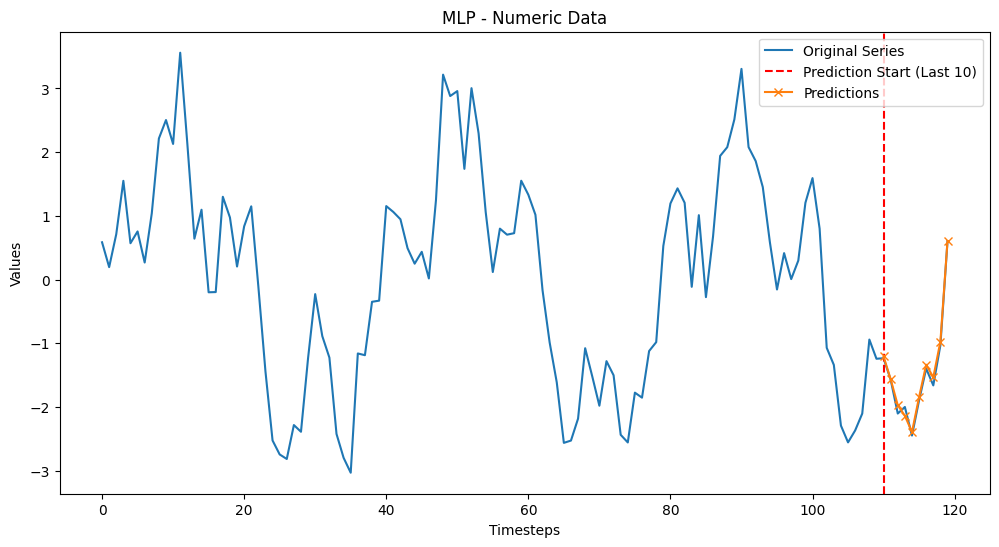

In [3]:
print("\nTask 1: Ψm,k predictor (Numeric)")

train_num, target_num = prepare_train_and_target(numeric_sequence, k)

mlp_model_num = create_mlp_model(input_dim=m, output_dim=k, numeric=True)
mlp_model_num.fit(train_num.reshape(1, -1), target_num.reshape(1, -1), epochs=250, batch_size=1, verbose=0)
mlp_prediction_num = mlp_model_num.predict(train_num.reshape(1, -1))[0]

plot_series_with_predictions(numeric_sequence, mlp_prediction_num, k, title="MLP - Numeric Data")

In [5]:
print("\nTask 1: Ψm,k predictor (Symbolic MultiOutput)")

# symbolic balanced
symbolic_sequence = create_balanced_symbolic_sequence(M)

encoder = LabelEncoder()
symbolic_sequence_encoded = encoder.fit_transform(symbolic_sequence)

train_sym, target_sym = prepare_train_and_target(symbolic_sequence_encoded, k)
target_sym_onehot = to_categorical(target_sym, num_classes=len(encoder.classes_))
train_sym_reshaped = train_sym.reshape(1, -1)
target_sym_onehot_flat = target_sym_onehot.reshape(1, -1)

mlp_model_sym = create_mlp_model(input_dim=m, output_dim=k * len(encoder.classes_))

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
mlp_model_sym.fit(
    train_sym_reshaped,
    target_sym_onehot_flat,
    epochs=1000,
    batch_size=1,
    verbose=0,
    callbacks=[early_stopping]
)

probs = mlp_model_sym.predict(train_sym_reshaped).reshape(k, -1)
mlp_predictions = probs.argmax(axis=1)
mlp_prediction_sym_decoded = encoder.inverse_transform(mlp_predictions)

print("Distribuzione delle classi:", collections.Counter(symbolic_sequence))
print("Sequence:",symbolic_sequence)
print("Original Symbolic Sequence:", symbolic_sequence[-k:])
print("Predicted Symbols:", mlp_prediction_sym_decoded)


Task 1: Ψm,k predictor (Simbolico Multi-Step)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Distribuzione delle classi: Counter({'I': 8, 'G': 7, 'B': 7, 'M': 7, 'V': 6, 'C': 6, 'K': 6, 'S': 5, 'W': 5, 'D': 5, 'J': 5, 'A': 4, 'Y': 4, 'E': 4, 'X': 4, 'H': 4, 'N': 4, 'P': 4, 'F': 4, 'O': 4, 'T': 4, 'U': 3, 'Q': 3, 'Z': 3, 'R': 3, 'L': 1})
Sequence: ['A' 'G' 'S' 'B' 'B' 'U' 'Y' 'E' 'G' 'M' 'Y' 'W' 'M' 'D' 'X' 'M' 'B' 'Q'
 'I' 'Z' 'G' 'H' 'V' 'W' 'H' 'I' 'Z' 'V' 'D' 'B' 'M' 'N' 'P' 'R' 'D' 'E'
 'M' 'I' 'U' 'F' 'O' 'E' 'T' 'V' 'N' 'C' 'T' 'Z' 'E' 'K' 'W' 'J' 'U' 'D'
 'J' 'F' 'Q' 'G' 'C' 'C' 'C' 'W' 'J' 'V' 'T' 'M' 'X' 'F' 'A' 'B' 'X' 'S'
 'K' 'K' 'D' 'T' 'V' 'J' 'L' 'R' 'Q' 'O' 'B' 'Y' 'S' 'O' 'F' 'G' 'A' 'K'
 'X' 'B' 'N' 'H' 'W' 'K' 'C' 'M' 'Y' 'R' 'I' 'C' 'I' 'S' 'I' 'J' 'N' 'G'
 'S' 'G' 'K' 'H' 'O' 'I' 'A' 'P' 'P' 'I' 'V' 'P']
Original Symbolic Sequence: ['K' 'H' 'O' 'I' 'A' 'P' 'P' 'I' 'V' 'P']
Predicted Symbols: ['K' 'H' 'O' 'C' 'A' 'C' 'P' 'W' 'K' 'P']



Task 2: Ψm,→n,k predictor (Numeric with LSTM)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


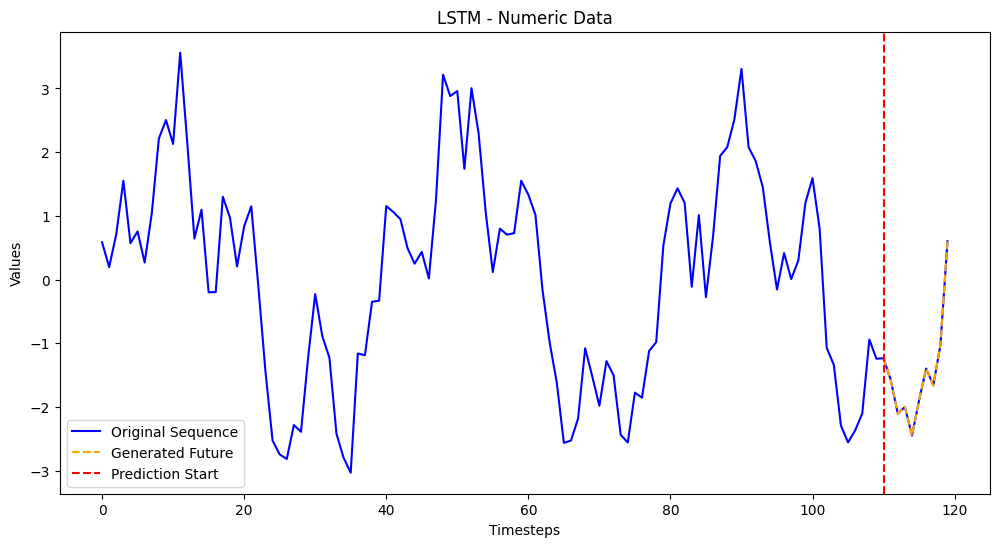

In [79]:
print("\nTask 2: Ψm,→n,k predictor (Numeric with LSTM)")
lstm_model_num = create_lstm_model(input_shape=(m, 1), numeric=True)
train_num_lstm = train_num.reshape(1, -1, 1)
lstm_model_num.fit(train_num_lstm, target_num.reshape(1, -1), epochs=250, batch_size=1, verbose=0)
lstm_prediction_num = lstm_model_num.predict(train_num_lstm)

plot_series_with_predictions(numeric_sequence, lstm_prediction_num, k, title="Ensemble - Numeric Data")


Task 3: Ensemble of Predictors (Numerico)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


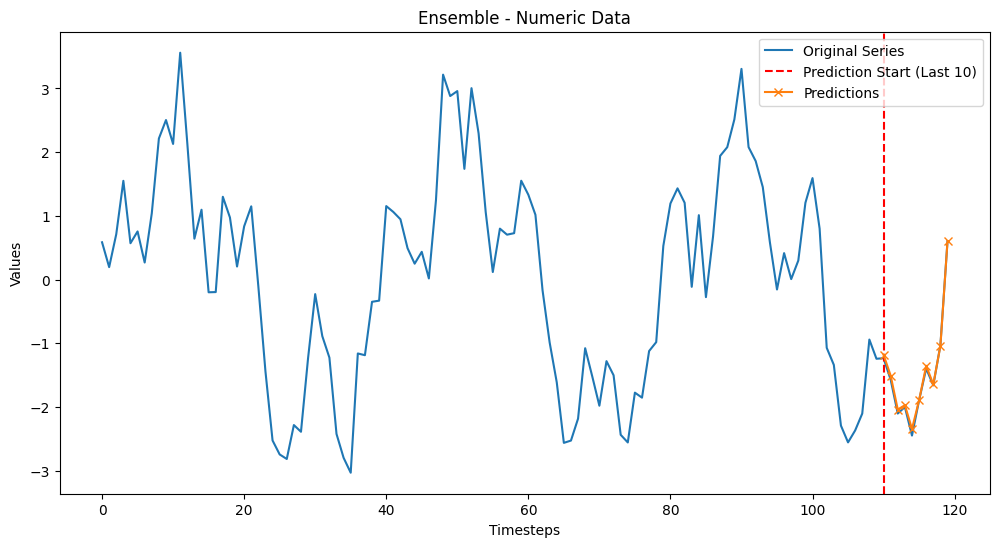

In [7]:
print("\nTask 3-4: Ensemble of Predictors (Numerico)")
ensemble_predictions = []
h = 10
for _ in range(h): # ensemble
        model = create_mlp_model(input_dim=m, output_dim=k, numeric=True)
        model.fit(train_num.reshape(1, -1), target_num.reshape(1, -1), epochs=250, batch_size=1, verbose=0)
        prediction = model.predict(train_num.reshape(1, -1))[0]
        ensemble_predictions.append(prediction)

ensemble_mean_prediction = np.mean(ensemble_predictions, axis=0)
plot_series_with_predictions(numeric_sequence, ensemble_mean_prediction, k, title="Ensemble - Numeric Data")

In [83]:
M = 250  # changing window
k = 30
m = M - k
numeric_sequence, _ = createSequence(M)


Task 5
Numeric Sequence: [ 1.16896932e+00  3.34301663e-01  2.58692311e-01  3.45016160e-01
  9.29814031e-01  1.42336560e+00  8.76722505e-01  1.60868372e+00
  1.80144825e+00  2.74604019e+00  3.56033367e+00  2.16967662e+00
  2.68069468e+00  1.86140881e+00  7.11483424e-01  1.78316450e+00
 -7.11423853e-01  3.57917875e-01  6.72299852e-01  2.11528041e+00
  7.05326923e-01 -4.12454040e-02 -2.85954880e-01 -8.19968476e-01
 -1.63237227e+00 -3.57225897e+00 -2.68791977e+00 -2.37877255e+00
 -2.27261584e+00 -1.79694638e+00 -1.17149022e+00 -8.48197035e-01
 -1.59141924e+00 -2.50717682e+00 -2.19398550e+00 -3.03118712e+00
 -7.88472308e-01 -1.34022067e+00 -4.09425949e-01  5.81078636e-01
  1.40333954e+00  1.88794307e-01  8.28146693e-01  3.43010375e-01
  6.40122575e-01  5.31103212e-01  6.08886418e-01  1.47391069e+00
  1.66147653e+00  2.42880580e+00  2.31908820e+00  2.90960856e+00
  1.52667923e+00  1.30973246e+00  9.51482007e-01  9.70961024e-02
 -3.15483737e-01  1.09178704e+00  9.91011799e-01  9.76518363e-01

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

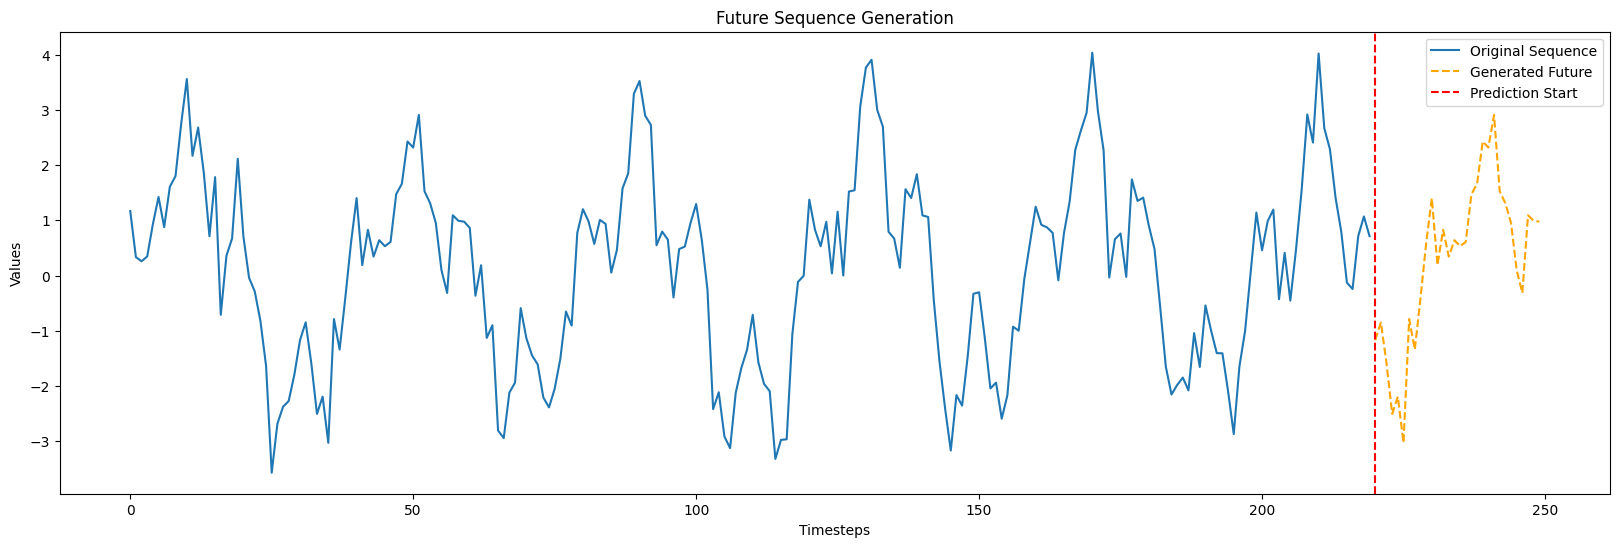

Scaler data min: [-3.57225897]
Scaler data max: [4.03642327]
Generated future values: [-1.42476369e-02 -8.64971327e-01 -8.08631545e-01 -4.36917373e-01
 -9.94214312e-01 -3.48835748e-02 -9.59928857e-01  5.76017500e-01
 -3.10250624e-01 -6.37972807e-01  8.37178658e-01  1.45902501e-01
 -7.54643821e-02 -1.63282995e+00 -2.79850059e+00  1.74655446e-01
 -2.51080092e+00  1.28796993e+00 -9.49407814e-01  7.59223208e-01
  1.86474422e+00  3.71402898e-01  3.46859349e+00  4.48773330e-01
  3.16978357e-01  7.99919803e-01  1.65295715e+00  2.62888007e+00
 -2.86918014e-01  1.75550943e+00  3.89997008e-01  5.85156293e-01
 -6.12772347e-01 -7.36540356e-01 -2.04456255e+00 -1.68483302e+00
  7.13184947e-03 -2.27730736e+00 -5.14623107e-01 -6.78151717e-01
 -1.22995953e-01 -1.85028710e-01 -6.39895531e-01 -1.69787264e+00
 -2.17972705e+00 -9.81237043e-01 -1.62314269e+00 -8.00651278e-02
 -1.63911893e+00  2.44295600e-01  1.46956065e+00  1.74202019e-01
  1.47445711e+00 -4.02003407e-01 -1.82401085e-01  6.13813427e-01
  5.

In [85]:
print("\nTask 5")
print("Numeric Sequence:", numeric_sequence)

scaler = MinMaxScaler(feature_range=(-1, 1))
numeric_sequence_scaled = scaler.fit_transform(numeric_sequence.reshape(-1, 1)).flatten()

future_sequence = list(numeric_sequence_scaled[-m:])

for step in range(k):
    input_sequence = np.array(future_sequence[-m:])
    next_prediction = mlp_model_num.predict(input_sequence.reshape(1, -1)).reshape(k,)
    future_sequence.extend(next_prediction)

future_sequence_rescaled = scaler.inverse_transform(np.array(future_sequence).reshape(-1, 1)).flatten()

plt.figure(figsize=(20, 6))
plt.plot(range(len(numeric_sequence[:-k])), numeric_sequence[:-k], label="Original Sequence")


plt.plot(range(len(numeric_sequence[:-k]), len(numeric_sequence[:-k]) + k),
         future_sequence_rescaled[:k],
         label="Generated Future", linestyle="--", color='orange')

plt.title("Future Sequence Generation")
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.axvline(x=len(numeric_sequence[:-k]), color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.show()

print("Scaler data min:", scaler.data_min_)
print("Scaler data max:", scaler.data_max_)
print("Generated future values:", future_sequence_rescaled[len(numeric_sequence):])

In [ ]:
def generate_dna_sequence(length):
    bases = ['A', 'T', 'C', 'G']
    dna_sequence = ''.join(choices(bases, k=length))
    if length % 3 != 0:
        dna_sequence = dna_sequence[:length - (length % 3)]
    
    return dna_sequence

In [ ]:
# Task Multi-Step per Dati Simbolici
print("\n predictor (Simbolico Multi-Step)")

SYMBOLIC = 120
m = SYMBOLIC - k

# DNA
symbolic_sequence = np.array(list(generate_dna_sequence(SYMBOLIC)))
encoder = LabelEncoder()
symbolic_sequence_encoded = encoder.fit_transform(symbolic_sequence)

train_sym, target_sym = prepare_train_and_target(symbolic_sequence_encoded, k)
target_sym_onehot = to_categorical(target_sym, num_classes=len(encoder.classes_))
train_sym_reshaped = train_sym.reshape(1, -1)
target_sym_onehot_flat = target_sym_onehot.reshape(1, -1)

mlp_model_sym = create_mlp_model(input_dim=m, output_dim=k * len(encoder.classes_))

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
mlp_model_sym.fit(
    train_sym_reshaped,
    target_sym_onehot_flat,
    epochs=1000,
    batch_size=1,
    verbose=0,
    callbacks=[early_stopping]
)

probs = mlp_model_sym.predict(train_sym_reshaped).reshape(k, -1)
mlp_predictions = probs.argmax(axis=1)
mlp_prediction_sym_decoded = encoder.inverse_transform(mlp_predictions)

print("Distribuzione delle classi:", collections.Counter(symbolic_sequence))
print("Sequence:",symbolic_sequence)
print("Original Symbolic Sequence:", symbolic_sequence[-k:])
print("Predicted Symbols:", mlp_prediction_sym_decoded)


Task 1: Ψm,k predictor (Simbolico Multi-Step)
Symbolic sequence ['C' 'A' 'G' 'T' 'C' 'A' 'T' 'G' 'T' 'G' 'T' 'C' 'T' 'T' 'A' 'T' 'A' 'C'
 'T' 'T' 'G' 'A' 'T' 'A' 'T' 'A' 'C' 'G' 'T' 'A' 'G' 'C' 'C' 'G' 'G' 'C'
 'G' 'C' 'T' 'G' 'G' 'A' 'C' 'A' 'C' 'C' 'C' 'C' 'A' 'C' 'G' 'A' 'T' 'C'
 'G' 'C' 'A' 'C' 'C' 'T' 'A' 'T' 'G' 'T' 'C' 'C' 'T' 'T' 'T' 'T' 'T' 'T'
 'G' 'T' 'T' 'A' 'T' 'A' 'A' 'G' 'A' 'C' 'T' 'A' 'T' 'A' 'G' 'G' 'A' 'G'
 'T' 'C' 'T' 'C' 'T' 'A' 'C' 'A' 'T' 'C' 'T' 'A' 'G' 'C' 'C' 'G' 'G' 'C'
 'T' 'A' 'G' 'T' 'C' 'C' 'G' 'A' 'C' 'T' 'C' 'A']


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Distribuzione delle classi: Counter({'T': 36, 'C': 33, 'A': 27, 'G': 24})
Sequence: ['C' 'A' 'G' 'T' 'C' 'A' 'T' 'G' 'T' 'G' 'T' 'C' 'T' 'T' 'A' 'T' 'A' 'C'
 'T' 'T' 'G' 'A' 'T' 'A' 'T' 'A' 'C' 'G' 'T' 'A' 'G' 'C' 'C' 'G' 'G' 'C'
 'G' 'C' 'T' 'G' 'G' 'A' 'C' 'A' 'C' 'C' 'C' 'C' 'A' 'C' 'G' 'A' 'T' 'C'
 'G' 'C' 'A' 'C' 'C' 'T' 'A' 'T' 'G' 'T' 'C' 'C' 'T' 'T' 'T' 'T' 'T' 'T'
 'G' 'T' 'T' 'A' 'T' 'A' 'A' 'G' 'A' 'C' 'T' 'A' 'T' 'A' 'G' 'G' 'A' 'G'
 'T' 'C' 'T' 'C' 'T' 'A' 'C' 'A' 'T' 'C' 'T' 'A' 'G' 'C' 'C' 'G' 'G' 'C'
 'T' 'A' 'G' 'T' 'C' 'C' 'G' 'A' 'C' 'T' 'C' 'A']
Original Symbolic Sequence: ['G' 'T' 'C' 'C' 'G' 'A' 'C' 'T' 'C' 'A']
Predicted Symbols: ['G' 'A' 'C' 'T' 'G' 'A' 'G' 'T' 'C' 'A']
